<p style="text-align:center;font-size:30px ;font-weight: bold; line-height: 40px;"> Where Is The Stop? <p/>
<p style="text-align:center; font-size:15px;  font-weight: bold;"> Detecting stop point in the NSW area of Australia<p/>
<p style="text-align:left;  line-height: 0px;font-weight: bold;"> November 3, 2021<p/>
<p style="text-align:left;  line-height: 0px;font-weight: bold;"> by: Rama Salahat<p/>



# `Importing Packages`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import json
import folium
import geopatra
from shapely.geometry import Point, LineString, shape 
from geopandas import GeoSeries
sns.set(style='whitegrid')
import contextily

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import warnings
warnings.filterwarnings("ignore")

# `Step-1: Reading The Full Data and Subsetting`

In [2]:
import glob
# get all files ending with .json with depth of 3 folders
paths = glob.glob("GTFS-R_Bus_Vehpos_20210518/*/*/*/*.json") 

In [3]:
#choosing the routes from 9am(in the data it's hour 0)
with open(paths[5]) as data_file:    
    d= json.load(data_file)  

#normalizing the json
df = pd.json_normalize(d, 'Entities')
#filtering columns
df = df[["Vehicle.Trip.TripId", "Vehicle.Trip.RouteId", "Vehicle.Trip.StartTime", "Vehicle.Position.Latitude", "Vehicle.Position.Longitude", "Vehicle.Position.Bearing", "Vehicle.Position.Speed"]]
#exporting the routes 
routes = pd.DataFrame(df[df["Vehicle.Trip.TripId"].isin(merged_stops_data.trip_id.unique())]["Vehicle.Trip.RouteId"].value_counts())[:20].reset_index()["index"]

In [5]:

for path in paths:
    with open(path) as data_file:    
        d= json.load(data_file)  
    
    #normalizing the json
    df = pd.json_normalize(d, 'Entities')
    #filtering columns
    df = df[["Vehicle.Timestamp", "Vehicle.Trip.TripId", "Vehicle.Trip.RouteId", "Vehicle.Trip.StartTime", "Vehicle.Position.Latitude", "Vehicle.Position.Longitude", "Vehicle.Position.Bearing", "Vehicle.Position.Speed"]]
    
    #filtering the data upon chooden routes
    df = df[df["Vehicle.Trip.RouteId"].isin(routes)]
    #appending the results 
    df.to_csv("data2.csv", mode='a', header=None)
    

# `Step-2: Reading and Exploring The Cleaned Data`

In [2]:
df = pd.read_csv("data2.csv", header = None, names=["index", "timestamp", "trip_id", "route_id", "starttime", "latitude", "longitude", "bearing", "speed"], index_col="index", )
df

,timestamp,trip_id,route_id,starttime,latitude,longitude,bearing,speed
index,,,,,,,,
574,1621295990,1304262,2435_T80,09:40:00,-33.83699,150.92494,281.00000,0.00000
579,1621295989,1353322,2435_804,08:08:00,-33.82224,150.99547,10.00000,0.00000
581,1621295988,1304261,2435_T80,09:30:00,-33.85296,150.89664,170.00000,12.40000
582,1621295992,1304226,2435_T80,09:10:00,-33.92765,150.88275,88.00000,8.20000
584,1621295990,1304227,2435_T80,09:20:00,-33.90761,150.87553,185.00000,1.60000
...,...,...,...,...,...,...,...,...
1940,1621382369,1375543,2459_420,09:33:00,-33.93246,151.16441,111.00000,9.40000
1942,1621382373,1265692,2459_438X,09:20:00,-33.88002,151.20898,18.00000,4.20000
1947,1621382371,1332027,2441_333,09:48:00,-33.89278,151.25534,266.00000,7.00000


In [3]:
df = df.dropna()

In [4]:
# setting the projection to be Australian datum 94 
gdf = geopandas.GeoDataFrame(df, crs = 4326, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
gdf = gdf.to_crs(4283)

## `Reading the full GTFS data and Merging it with the GTFS-R`

In [5]:
stop_times = pd.read_csv ('latest/stop_times.txt')[["trip_id", "stop_id", "stop_sequence", "shape_dist_traveled"]]
stops = pd.read_csv ('latest/stops.txt')[["stop_id", "stop_lat", "stop_lon"]]
trips = pd.read_csv('latest/trips.txt')

In [6]:
#setting trip and route ids to string for compatibility 
stop_times["trip_id"] = stop_times["trip_id"].astype(str)
stop_times["stop_id"] = stop_times["stop_id"].astype(str)
stops["stop_id"] = stops["stop_id"].astype(str)
gdf["trip_id"] = gdf["trip_id"].astype(str)
trips["trip_id"] = trips["trip_id"].astype(str)

In [7]:
#filtering the trips to the choosen routes' trips
trips = trips[trips["trip_id"].isin(gdf.trip_id)]

In [8]:
#filtering the stop times to the choosen routes' trips
stop_times = stop_times[stop_times["trip_id"].isin(gdf["trip_id"])]

In [9]:
#merging the full gtfs data together 
merged_stops_data = stop_times.merge(stops, how="left")
merged_stops_data.to_csv("merged_stops_data.csv")

In [10]:
merged_stops_data

,trip_id,stop_id,stop_sequence,shape_dist_traveled,stop_lat,stop_lon
0,1049226,2176253,1,0.00000,-33.88560,150.88730
1,1049226,2176197,2,658.90000,-33.88135,150.88926
2,1049226,2176198,3,1014.56000,-33.87904,150.89194
3,1049226,2176199,4,1367.22000,-33.87677,150.89239
4,1049226,2176200,5,1754.23000,-33.87393,150.89001
...,...,...,...,...,...,...
193172,1358609,202511,37,11535.42000,-33.88870,151.23232
193173,1358609,202512,38,11854.13000,-33.89004,151.23527
193174,1358609,202238,39,12598.64000,-33.89040,151.24303
193175,1358609,202240,40,13050.91000,-33.89165,151.24713


In [13]:
# reading the shapes of routes data and filtering it to the choosen subset of data
shapes = pd.read_csv ('latest/shapes.txt')
shapes = shapes[shapes["shape_id"].isin(trips.shape_id.unique())]

In [14]:
#defining shapely points
shapes["geometry"] = geopandas.points_from_xy(shapes.shape_pt_lon, shapes.shape_pt_lat)

In [15]:
# creating line strings of the points of shapes representing the streets
streets = shapes.groupby("shape_id").agg(
     geometry = pd.NamedAgg(column='geometry', aggfunc = lambda x: LineString(x.values))
    ).reset_index()

In [16]:
# projecting the streets line strings to the australian datum 94
streets = geopandas.GeoDataFrame(streets[["shape_id"]], crs = 4326, geometry=streets["geometry"])
streets = streets.to_crs(4283)

In [20]:
# define geopandas dataframe for stops and project the points
merged_stops_data = geopandas.GeoDataFrame(merged_stops_data, crs = 4326, geometry=geopandas.points_from_xy(merged_stops_data.stop_lon, merged_stops_data.stop_lat))
merged_stops_data = merged_stops_data.to_crs(4283)

## `Generating Labels for the GTFS-R data from the full GTFS data `

In [21]:
#buffering stops to account for misscalculations of location
bufferd_stops = merged_stops_data['geometry'].buffer(0.001)

In [22]:
#define a geodataframe for buffered stopps
bufferd_stops = geopandas.GeoDataFrame(merged_stops_data[['trip_id', 'stop_id', 'stop_sequence', 'shape_dist_traveled',
       'stop_lat', 'stop_lon']], crs = 4283, geometry=bufferd_stops)

(150.84374851002673, 151.01812053606204)

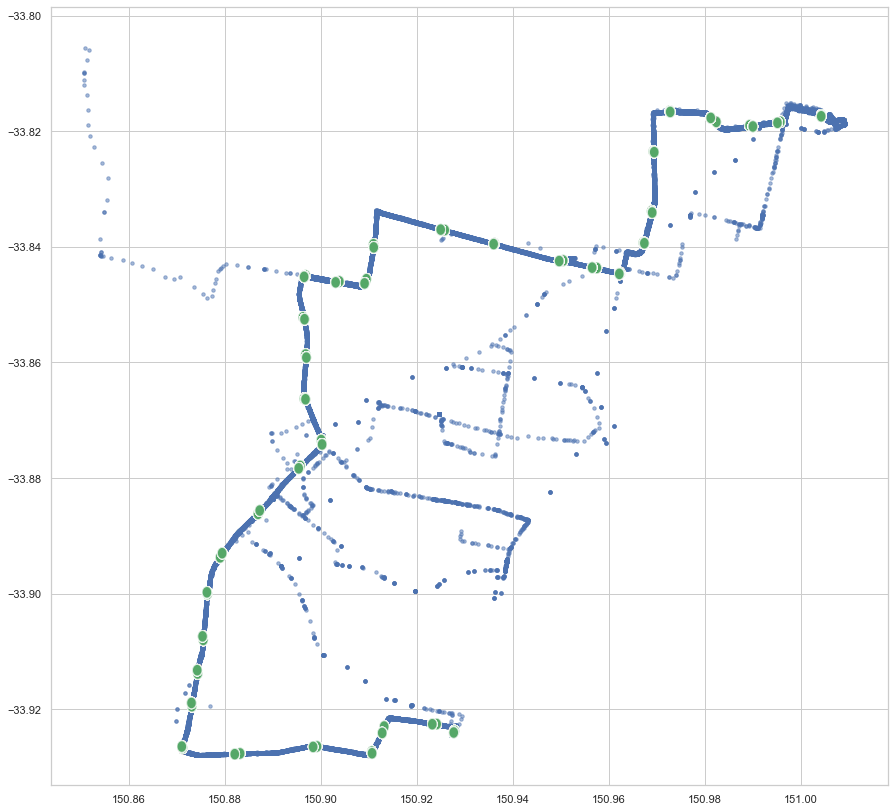

In [23]:
#plot buffered stops on the map
fig, ax = plt.subplots(figsize=(15,15))
gdf[gdf["route_id"]=="2435_T80"].plot(ax=ax, marker='o', color='b', markersize=12, alpha=0.5)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

merged_stops_data[merged_stops_data["trip_id"].isin(gdf[gdf["route_id"]=="2435_T80"]["trip_id"].unique())].plot(ax=ax, marker='o', color='r', markersize=15, alpha=1)

bufferd_stops[bufferd_stops["trip_id"].isin(gdf[gdf["route_id"]=="2435_T80"]["trip_id"].unique())].plot(ax=ax, marker='o', color='g', alpha=0.5)



# streets.plot(ax=ax, color='gray', alpha=0.01)
plt.ylim([ymin + 0.001, ymax + 0.001])
plt.xlim([xmin + 0.001, xmax + 0.001])


### `Merging the buffered stops with the GTFS-R data `

In [52]:
gdf["is_at_stop"] = 0

In [50]:
gdf = gdf.reset_index(drop=True)

In [30]:
# iterating over the routes to utilize memory usage since the data is so big, by computing on subsets of the data 
for route_id in gdf.route_id.unique():
    #get subset of the data on route
    data = gdf[gdf["route_id"] == route_id]
    #get subset of buffered stops on route
    subset_of_buffered_stops = bufferd_stops[bufferd_stops["trip_id"].isin(data.trip_id.unique())]
    #create an index for the stops 
    ind = subset_of_buffered_stops.geometry.sindex
    #getting the count of intersection for each point with the buffered srops
    gdf.loc[gdf["route_id"] == route_id, 'is_at_stop'] = data.geometry.apply(lambda x: len(ind.query(x, predicate="intersects")))


In [62]:
# point were considered stops when they intersect with any of the schdeuled stop and their speed was 0  
gdf['label'] = np.where(((gdf['zero_speed']==1) & (gdf['is_at_stop']> 0) ), 1, 0)

In [63]:
gdf.describe()

,timestamp,latitude,longitude,bearing,speed,zero_speed,is_at_stop,label
count,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000,1371020.00000
mean,1621334660.57218,-33.86123,151.14399,172.61749,5.40489,0.32993,117.79755,0.43284
std,27868.61319,0.06918,0.11555,105.00890,5.30149,0.47019,106.96688,0.49547
min,1621295749.00000,-34.08822,150.85068,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1621312880.00000,-33.90277,151.04280,89.00000,0.00000,0.00000,0.00000,0.00000
50%,1621325426.00000,-33.88000,151.18008,178.00000,4.60000,0.00000,119.00000,0.00000
75%,1621369171.00000,-33.82405,151.23799,268.00000,9.70000,1.00000,185.00000,1.00000
max,1621382381.00000,-33.59224,151.33432,360.00000,28.00000,1.00000,841.00000,1.00000


(150.84374851002673, 151.01812053606204)

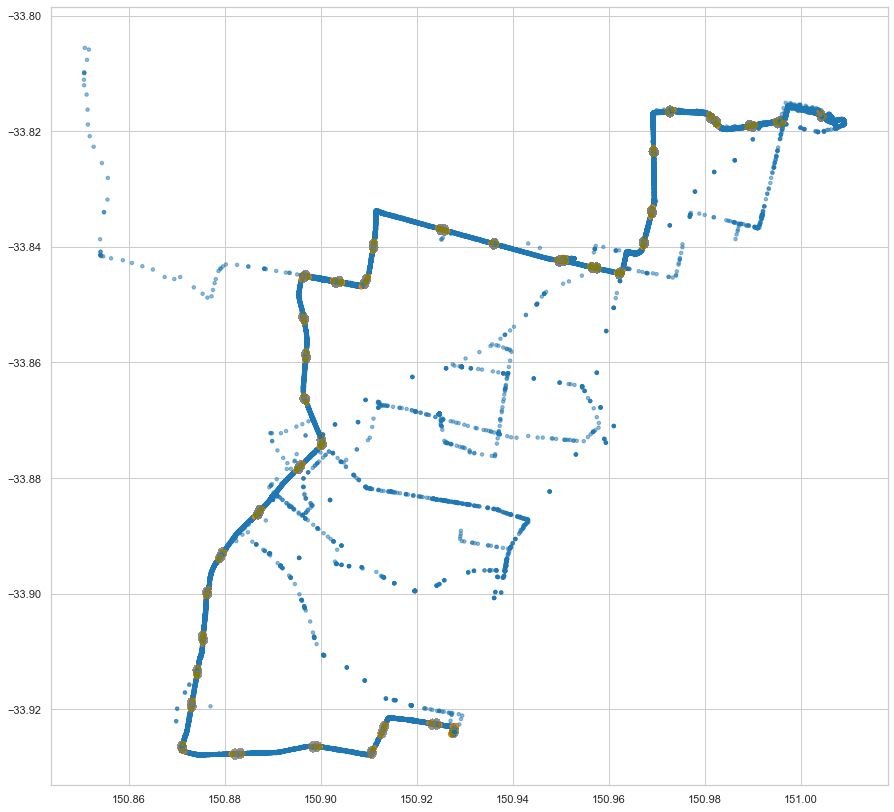

In [107]:
# here the labeled stops were plotted as orange points, and buffered stops were ploted as grey dots
fig, ax = plt.subplots(figsize=(15,15))
colors = {0:'tab:blue', 1:'tab:orange'}
data = gdf[gdf["route_id"]=="2435_T80"]
data.plot(ax=ax, marker='o', markersize=12, alpha=0.5,legend=True, c=data['label'].map(colors) )
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()


bufferd_stops[bufferd_stops["trip_id"].isin(data["trip_id"].unique())].plot(ax=ax, marker='x', color='grey', alpha=0.005)

plt.ylim([ymin + 0.001, ymax + 0.001])
plt.xlim([xmin + 0.001, xmax + 0.001])


# `Plotting A Route`

(150.84374851002673, 151.01812053606204)

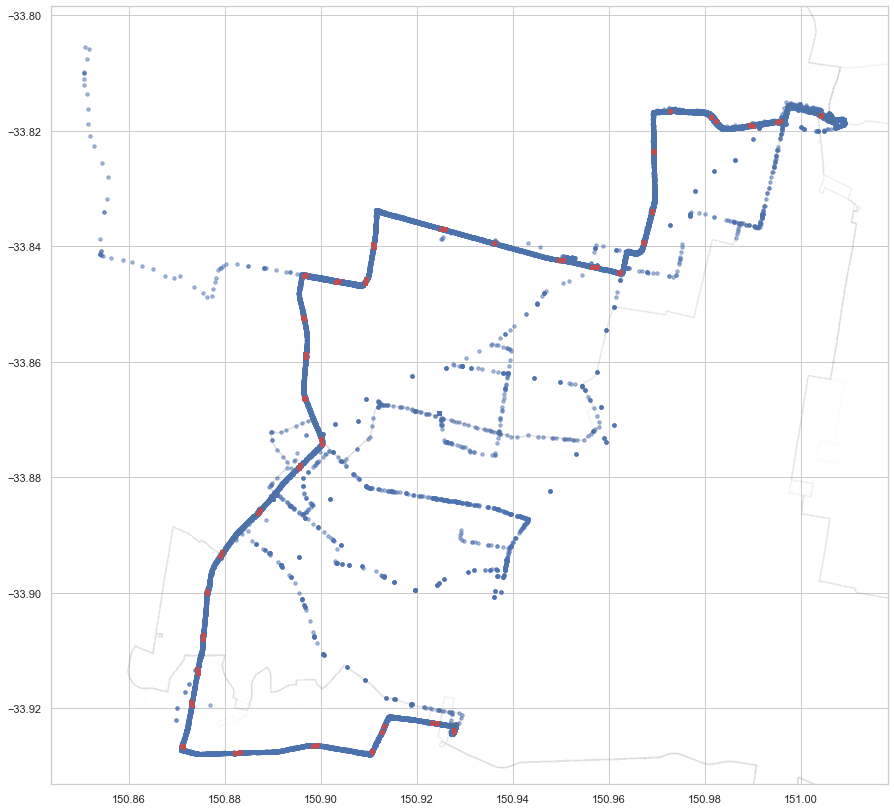

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
gdf[gdf["route_id"]=="2435_T80"].plot(ax=ax, marker='o', color='b', markersize=12, alpha=0.5)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

merged_stops_data[merged_stops_data["trip_id"].isin(gdf[gdf["route_id"]=="2435_T80"]["trip_id"].unique())].plot(ax=ax, marker='o', color='r', markersize=15, alpha=1)

streets.plot(ax=ax, color='gray', alpha=0.01)
plt.ylim([ymin + 0.001, ymax + 0.001])
plt.xlim([xmin + 0.001, xmax + 0.001])


In [19]:
gdf["zero_speed"] = np.where(df['speed']==0, 1, 0)

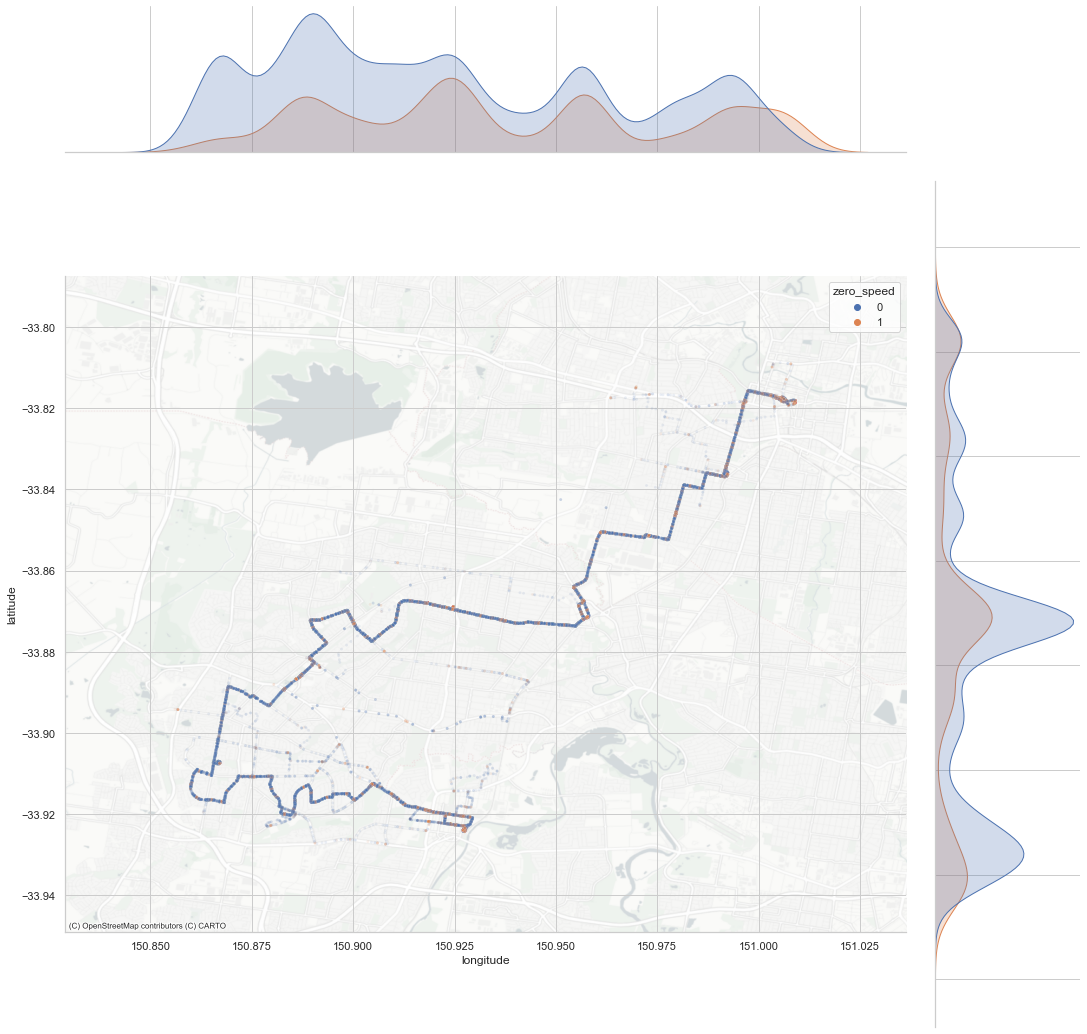

In [30]:
joint_axes = seaborn.jointplot(
    x='longitude', y='latitude', data=gdf[gdf["route_id"]=="2435_804"], s=8, height =15, alpha = 0.1, hue="zero_speed"
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4283",
    source=contextily.providers.CartoDB.PositronNoLabels
);

In [111]:
#exporting the data
gdf.to_csv("labeledData.csv")